ValueError: cannot reshape array of size 496 into shape (31,)

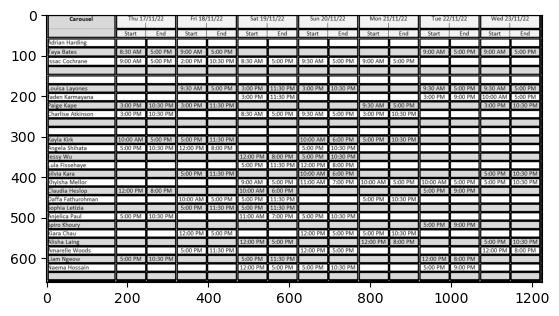

In [14]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

#read your file
file=r'./Roster2.jpg'
img = cv2.imread(file,0)
img.shape

#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#inverting the image 
img_bin = 255-img_bin
cv2.imwrite('/Users/marius/Desktop/cv_inverted.png',img_bin)
#Plotting the image to see the output
plotting = plt.imshow(img_bin,cmap='gray')

# countcol(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("/Users/marius/Desktop/vertical.jpg",vertical_lines)
#Plot the generated image
plotting = plt.imshow(image_1,cmap='gray')

#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("/Users/marius/Desktop/horizontal.jpg",horizontal_lines)
#Plot the generated image
plotting = plt.imshow(image_2,cmap='gray')

# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("/Users/marius/Desktop/img_vh.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)
#Plotting the generated image
plotting = plt.imshow(bitnot,cmap='gray')

# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

#Get mean of heights
mean = np.mean(heights)

#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
        
plotting = plt.imshow(image,cmap='gray')

#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0

#Sorting the boxes to their respective row and column
for i in range(len(box)):    
        
    if(i==0):
        column.append(box[i])
        previous=box[i]    
    
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]            
            
            if(i==len(box)-1):
                row.append(column)        
            
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
            

#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]

center=np.array(center)
center.sort()
#Regarding the distance to the columns center, the boxes are arranged in respective order

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)


#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=2)
                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)

#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
#data = dataframe.style.set_properties(align="left")
#Converting it in a excel-file
#data.to_excel("./output2.xlsx")

In [303]:
from numpy import logical_not
from tabulate import tabulate

msk = logical_not(dataframe.iloc[:, :].eq(' ').all(axis= 1))
dataframe[msk]

npDF = dataframe[msk].iloc[:,:-1].to_numpy()    

new = [[x.replace('\n', '').strip().replace('|', '') for x in i] for i in npDF]
new = [[' ' if len(x) < 3 else x for x in i] for i in new]
headers = new[0]
def printTable(array, headers):
    print(tabulate(array, headers, tablefmt='fancy_grid'))
    return

dictHeaders = ['Staff Name', headers[1].split(' ')[1], headers[1].split(' ')[1], headers[3].split(' ')[1], headers[3].split(' ')[1], headers[5].split(' ')[1], headers[5].split(' ')[1], headers[7].split(' ')[1], headers[7].split(' ')[1], headers[9].split(' ')[1], headers[9].split(' ')[1], headers[11].split(' ')[1], headers[11].split(' ')[1], headers[13].split(' ')[1], headers[13].split(' ')[1]]
printTable(new[2:], dictHeaders)
myTimetable = 0
for i in new:
    if 'Daffa' in i[0]:
        myTimetable = [dictHeaders, i]
myShifts = [i for i in list(zip(*myTimetable))[1:] if i[1] != ' ']


╒═══════════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╕
│ Staff Name        │ 17/11/22   │ 17/11/22   │ 18/11/22   │ 18/11/22   │ 19/11/22   │ 19/11/22   │ 20/11/22   │ 20/11/22   │ 21/11/22   │ 21/11/22   │ 22/11/22   │ 22/11/22   │ 23/11/22   │ 23/11/22   │
╞═══════════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ Adrian Harding    │            │            │            │            │            │            │            │            │            │            │            │            │            │            │
├───────────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼───────

In [242]:
myShifts

[('18/11/22', '10:00 AM'),
 ('18/11/22', '5:00 PM'),
 ('19/11/22', '5:00 PM'),
 ('19/11/22', '11:30 PM'),
 ('21/11/22', '5:00 PM'),
 ('21/11/22', '10:30 PM')]

In [268]:
import datetime
lst = []


    
    

2022-11-18 10:00:00
2022-11-19 17:00:00
2022-11-21 17:00:00


In [300]:
import datetime
import os.path
import pytz


from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

# If modifying these scopes, delete the file token.json.

def convertTime(time):
    local = pytz.timezone('Australia/Perth')
    local_dt = local.localize(time, is_dst=None)
    utc_dt = local_dt.astimezone(pytz.utc)
    result = utc_dt.replace(tzinfo=None)  
    return result

def addEvent(creds, start, end):
    start = convertTime(start)
    end = convertTime(end)
    
    event = {
        'summary': 'iPlay Work',
        'start': {
            'dateTime': start.isoformat() + 'Z',
            'timeZone': 'Australia/Perth',
        },
        'end': {
            'dateTime': end.isoformat() + 'Z',
            'timeZone': 'Australia/Perth',
        },
    }

    service = build('calendar', 'v3', credentials=creds)
    event = service.events().insert(calendarId='ddarm4@gmail.com', body = event).execute()
    print(f"Event Created: {event.get('htmlLink')}")


def main():
    SCOPES = ['https://www.googleapis.com/auth/calendar']
    """Shows basic usage of the Google Calendar API.
    Prints the start and name of the next 10 events on the user's calendar.
    """
    creds = None
    # The file token.json stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.json'):
        creds = Credentials.from_authorized_user_file('token.json', SCOPES)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.json', 'w') as token:
            token.write(creds.to_json())
    StartingShifts = myShifts[0::2]
    EndingShifts = myShifts[1::2]
    for i in range(len(StartingShifts)):
        date = StartingShifts[i][0]
        startTime = StartingShifts[i][1]
        endTime = EndingShifts[i][1]
        start = datetime.datetime.strptime(f"{date}T{startTime}", '%d/%m/%yT%I:%M %p')
        end = datetime.datetime.strptime(f"{date}T{endTime}", '%d/%m/%yT%I:%M %p')
        addEvent(creds, start, end)
main()

Event Created: https://www.google.com/calendar/event?eid=bWVqMHZ0NDA0Y3F2cWc1Zmlmc3ZnY2I2NjQgZGRhcm00QG0
Event Created: https://www.google.com/calendar/event?eid=NjQ4dGdqcm52bnE4MXF0dTh2cTE3azVqaDAgZGRhcm00QG0
Event Created: https://www.google.com/calendar/event?eid=YmZqMzNja3BvNHJzODk3NWU1Njgzc2pndW8gZGRhcm00QG0


In [299]:
import pytz

date = '18/11/22'
startTime = '10:00 AM'

Time = datetime.datetime.strptime(f"{date}T{startTime}", '%d/%m/%yT%I:%M %p')
local = pytz.timezone('Australia/Perth')
local_dt = local.localize(Time, is_dst=None)
utc_dt = local_dt.astimezone(pytz.utc)
dt = utc_dt.replace(tzinfo=None)
dt.isoformat() + 'Z'

'2022-11-18T02:00:00Z'

In [306]:
round(32 / 5)

6

In [3]:
import urllib.request
def downloadFile(url):
    filename = './Downloads/Roster.jpg'
    # calling urlretrieve function to get resource
    urllib.request.urlretrieve(url, filename)
    return filename
downloadFile('https://nextlevel.worldmanager.com/content/forum_uploads/files/2304/Roster_WE_16_11_2022.jpg')